# An Analysis on Overwatch Roles
### Mathew Shi, Dasson Tan

In [49]:
import requests, json, re, warnings
import pandas as pd
import numpy as np
import random
from plotnine import *
from scipy.stats import ttest_ind

warnings.filterwarnings('ignore')

# Data Gathering

## Scraping Battletags

In order to analyze player data, we require a playerbase to assess. It is possible to compile a list of players by their battletags—unique player ID's connected to all Overwatch player accounts. Luckily, there are Overwatch databases that contain large amounts of information including battletags.  
   
One such online database is [Overwatch Tracker](https://overwatchtracker.com/). As such, Overwatch Tracker's leaderboard was used to obtain battletags. By scraping the leaderboard with the Beautiful Soup library, we were able to obtain roughly 36000 battletags of active Overwatch PC (non-console) players.

## Fetching Player Statistics

In [ ]:
# read in battletags
battletags_url = "https://raw.githubusercontent.com/Dst017/PDS_Project/main/battletags.csv"
tags = pd.read_csv(battletags_url, header = None).iloc[0, :]
tags = tags.map(lambda x: x.replace("#", "-"))
tags = tags.to_numpy()

# randomly sample battletags
indices = random.sample(range(tags.shape[0]), 15000)
tags = tags[indices]

Each member of this list of battletags can now be used as input into an Overwatch API that fetches player data. Rather than attempting to get player statistics on all 36000 battletags, 15000 randomly sampled battletags were used. It would have been ideal to use all 36000 battletags, but due to limitations on the speed at which the API could return data, a smaller sample was chosen.

In [ ]:
def getResponse(tag):
    call = "https://ow-api.com/v1/stats/pc/us/" + tags[i] + "/complete"
    response = requests.get(call)
    return response.json()

def wantedAllStats(json):
    all_dct = json["careerStats"]["allHeroes"]
    json["careerStats"] = all_dct
    return json

def badStats(dct):
    if ("error" in dct):
        return True
    elif (dct["private"]):
        return True
    elif (len(dct["competitiveStats"]["careerStats"]) == 0):
        return True
    elif (dct["ratings"] == None):
        return True
    else:
        return False

def createInstance(dct):
    try:
        if (badStats(dct)): return None
        ret_dct = dict()
        ret_dct["name"] = dct["name"]
        ret_dct["rating"] = dct["rating"]
        ret_dct["ratings"] = dct["ratings"]
        ret_dct = {**ret_dct, **wantedAllStats(dct["competitiveStats"])}
        
        return ret_dct
    except:
        return None         

# fetch data and save to list
profiles = []
for i in range(tags.shape[0]):
    if (i % 500 == 0): print(i)
    r_dct = getResponse(tags[i])
    r_dct = createInstance(r_dct)
    if (r_dct == None): continue
    profiles.append(r_dct)


Of the 15000 or so calls made by the API, only about half of them returned useable data. A number of the data points were lacking due to the respective players simply not playing enough of the game resulting in insufficient data. However, the vast majority of "bad" calls are due to private player profiles with stats hidden from public view, and as such, our Overwatch API is unable to grab data on such players. Our sample now consists of about 7500 instances, which is still a reasonable sample size.

# Massaging  the Data into a Useable Format
## Main Data Frame

In [2]:
df = pd.read_json("profiles15000.txt")
df.columns

Index(['name', 'rating', 'ratings', 'awards', 'careerStats', 'games',
       'topHeroes'],
      dtype='object')

Our Overwatch API returns results in json format, but it would be more convenient for us to put this information into data frames for analysis. The simple pandas read_json function results in a data frame with 7 columns. Many of these columns contain nested dictionaries or lists of dictionaries of data. It is thus necessary for us to go into these dictionaries to pull out the information that interests us.

### Skill Rating and Rank

In [3]:
# ratings df
def getRatings(dct_lst):
    return {dct["role"]:dct["level"] for dct in dct_lst}

def getRank(rating):
    if (rating == 0):
        return "unrated"
    elif (rating < 1500):
        return "bronze"
    elif (rating < 2000):
        return "silver"
    elif (rating < 2500):
        return "gold"
    elif (rating < 3000):
        return "platinum"
    elif (rating < 3500):
        return "diamond"
    elif (rating < 4000):
        return "master"
    else:
        return "grandmaster"

# create dataframe of skill ratings
df_ratings = df[["name", "rating", "ratings"]]
ratings_dct = df_ratings["ratings"].apply(lambda x: getRatings(x))
df_ratings = df_ratings.drop("ratings", axis = 1)
df_ratings["ratings"] = ratings_dct

# add in role specific ratings
df_ratings["tank_rating"] = df_ratings["ratings"].apply(lambda x: x["tank"] if "tank" in x else 0)
df_ratings["damage_rating"] = df_ratings["ratings"].apply(lambda x: x["damage"] if "damage" in x else 0)
df_ratings["support_rating"] = df_ratings["ratings"].apply(lambda x: x["support"] if "support" in x else 0)

# add in corresponding ranks
df_ratings["rank"] = df_ratings["rating"].apply(lambda x: getRank(x))
df_ratings["tank_rank"] = df_ratings["tank_rating"].apply(lambda x: getRank(x))
df_ratings["damage_rank"] = df_ratings["damage_rating"].apply(lambda x: getRank(x))
df_ratings["support_rank"] = df_ratings["support_rating"].apply(lambda x: getRank(x))

df_ratings = df_ratings.drop("ratings", axis = 1)
df_ratings.head()

,name,rating,tank_rating,damage_rating,support_rating,rank,tank_rank,damage_rank,support_rank
0,Mercy#24868,3764,0,3764,0,master,unrated,master,unrated
1,LazyTurtle#29116,2877,2576,3033,3022,platinum,platinum,diamond,diamond
2,Paperclip#11793,1966,0,0,1966,silver,unrated,unrated,silver
3,Chizzyfizzy#1504,2728,2639,2532,3015,platinum,platinum,platinum,diamond
4,shadowboy#11235,2324,2354,2414,2204,gold,gold,gold,gold


A subset of the data we are interested in is related to player skill ratings (SR). SR ranges from 1 - 5000 and is an in-game metric used to indicate how skilled a player is for Overwatch's competitive game mode. A discretized version of SR called rank also exists in the game. The lowest rank a player can have is bronze, and the highest is grandmaster. See the getRank function in the code cell above to see the order and binning of SR to rank.

### Roles
The above data frame shows ratings and ranks but seems to also break these down into different sub-groups: tank, damage, and support. This is due to a system known as role-queue.

The 32 playable heroes in Overewatch can actually be categorized into one of three different roles: tank, damage (DPS), or support. In short, tank heroes soak up damage and protect their teammates, DPS heroes deal damage, and support heroes heal their damaged teammmates.

Rather than allow players to choose any hero, the competitive game mode uses role-queue to ensure a even 2-2-2 distribution of tank, DPS, and support characters in a match. Players must decide which roles they would be open to playing when queueing up for a match. A player thus has three separate ratings each determined by the matches where he or she has played a particular role.

An overall player rating is simply an average of a player's three different ratings excluding those roles that a player does not play. For example, an individual with a 2000 tank rating, 3000 damage rating, and 0 support rating would have an overall rating of 2500. Note that all of these ratings translate over to rank using basic binning.

### Other Stats
Some other match-related stats are extracted by pulling out nested dictionaries from the initial data frame. Most of these other stats are averaged stats based on multiple matches.

In [4]:
# career stats
df_avg = pd.json_normalize([stats["average"] for stats in df["careerStats"]])

# games
df_games = pd.json_normalize(df["games"])

### Mains
It is difficult to play all 32 Overwatch hereos at a competitive level as these characters are all very unique. As such. Overwatch players tend to favor certain or small groups of characters to focus on playing. As a matter of fact, most players have a main—a most played character. We will use this notion of player mains to label players and can consequently also label players by their most played role by simply finding out which of the three roles a main character is in.

In [5]:
# top hero
def timeStringToSec(time_str):
    if (not isinstance(time_str, str)): return time_str
    times = time_str.split(":")
    sec = 0
    for i, time in enumerate(times[::-1]):
        sec += (60**i)*int(time)
    return sec

def getMain(dct_dct):
    df = pd.DataFrame([(k, v["timePlayed"]) for k, v in dct_dct.items()])
    df.columns = ["hero", "timePlayed"]
    df["timePlayedSec"] = df["timePlayed"].apply(lambda x: timeStringToSec(x))
    
    df = df.sort_values("timePlayedSec", ascending = False)
    return df.iloc[0, 0]
    
top_heroes = df["topHeroes"].apply(lambda x: getMain(x))
top_heroes.name = "top_hero"

# role
hero_dct = {"hanzo":"damage", "sombra":"damage", "baptiste":"support", 
            "ana":"support", "genji":"damage", "soldier76":"damage", 
            "mccree":"damage", "lucio":"support", "wreckingBall":"tank", 
            "junkrat":"damage", "sigma":"tank", "ashe":"damage", 
            "mercy":"support", "roadhog":"tank", "reinhardt":"tank", 
            "zarya":"tank", "winston":"tank", "orisa":"tank", 
            "torbjorn":"damage", "moira":"support", "reaper":"damage", 
            "doomfist":"damage", "widowmaker":"damage", "pharah":"damage", 
            "dVa":"tank", "echo":"damage", "tracer":"damage", 
            "bastion":"damage", "symmetra":"damage", "zenyatta":"support", 
            "mei":"damage", "brigitte":"support"}
    
roles = top_heroes.map(lambda x: hero_dct[x])
roles.name = "role"

In [6]:
df_final = pd.concat([df_ratings, top_heroes, roles, df_games, df_avg], axis = 1)
df_final = df_final.drop_duplicates()
print(df_final.columns)
df_final

Index(['name', 'rating', 'tank_rating', 'damage_rating', 'support_rating',
       'rank', 'tank_rank', 'damage_rank', 'support_rank', 'top_hero', 'role',
       'played', 'won', 'allDamageDoneAvgPer10Min',
       'barrierDamageDoneAvgPer10Min', 'deathsAvgPer10Min',
       'eliminationsAvgPer10Min', 'finalBlowsAvgPer10Min',
       'heroDamageDoneAvgPer10Min', 'objectiveKillsAvgPer10Min',
       'objectiveTimeAvgPer10Min', 'soloKillsAvgPer10Min',
       'timeSpentOnFireAvgPer10Min', 'healingDoneAvgPer10Min'],
      dtype='object')


,name,rating,tank_rating,damage_rating,support_rating,rank,tank_rank,damage_rank,support_rank,top_hero,...,barrierDamageDoneAvgPer10Min,deathsAvgPer10Min,eliminationsAvgPer10Min,finalBlowsAvgPer10Min,heroDamageDoneAvgPer10Min,objectiveKillsAvgPer10Min,objectiveTimeAvgPer10Min,soloKillsAvgPer10Min,timeSpentOnFireAvgPer10Min,healingDoneAvgPer10Min
0,Mercy#24868,3764,0,3764,0,master,unrated,master,unrated,hanzo,...,2110.0,7.78,31.89,23.14,10859.0,7.38,00:28,6.87,03:09,NaN
1,LazyTurtle#29116,2877,2576,3033,3022,platinum,platinum,diamond,diamond,sombra,...,2704.0,6.55,18.63,7.43,6816.0,6.58,00:47,1.29,00:44,1000.0
2,Paperclip#11793,1966,0,0,1966,silver,unrated,unrated,silver,baptiste,...,1837.0,6.77,13.00,4.38,3584.0,6.23,01:23,0.41,01:24,8872.0
3,Chizzyfizzy#1504,2728,2639,2532,3015,platinum,platinum,platinum,diamond,ana,...,2408.0,5.24,17.50,5.66,5879.0,7.29,01:09,0.84,00:42,5784.0
4,shadowboy#11235,2324,2354,2414,2204,gold,gold,gold,gold,genji,...,2907.0,9.09,18.88,8.30,6692.0,6.79,01:23,1.68,01:19,3067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7362,Kyrann#11390,2111,2116,2190,2028,gold,gold,gold,gold,zarya,...,4473.0,7.08,22.50,11.72,8421.0,10.50,01:37,1.79,01:46,2103.0
7363,tintix78#1300,2245,2245,0,0,gold,gold,unrated,unrated,reinhardt,...,1648.0,9.23,19.78,9.39,6959.0,6.26,00:56,2.14,01:24,NaN
7364,Seagull#11814,2154,2048,2064,2352,gold,gold,gold,gold,ana,...,2007.0,6.86,14.32,4.01,4088.0,6.89,01:11,0.58,00:50,6688.0
7366,Jocab#11391,3323,3537,2985,3449,diamond,master,platinum,diamond,zenyatta,...,4179.0,7.69,16.84,5.21,6245.0,6.71,00:59,0.34,00:54,5253.0


Above is our main data frame in its final form. Column names are also printed out for convenience.

## Hero data frame

In [7]:
def playerHeroLst(dct_dct):
    return [{**{"hero":k}, **v} for k, v in dct_dct.items()]

df_heroes = df["name"].to_frame()
df_heroes["heroes"] = df["topHeroes"].apply(lambda x: playerHeroLst(x))
print(df_heroes["heroes"][0][0].keys())
df_heroes

dict_keys(['hero', 'timePlayed', 'gamesWon', 'winPercentage', 'weaponAccuracy', 'eliminationsPerLife', 'multiKillBest', 'objectiveKills'])


,name,heroes
0,Mercy#24868,"[{'hero': 'ashe', 'timePlayed': '31:22', 'game..."
1,LazyTurtle#29116,"[{'hero': 'ana', 'timePlayed': '01:32:27', 'ga..."
2,Paperclip#11793,"[{'hero': 'ana', 'timePlayed': '26:21', 'games..."
3,Chizzyfizzy#1504,"[{'hero': 'ana', 'timePlayed': '55:24', 'games..."
4,shadowboy#11235,"[{'hero': 'ana', 'timePlayed': '40:33', 'games..."
...,...,...
7363,tintix78#1300,"[{'hero': 'dVa', 'timePlayed': '01:43', 'games..."
7364,Seagull#11814,"[{'hero': 'ana', 'timePlayed': '06:24:26', 'ga..."
7365,Bionic#21127,"[{'hero': 'orisa', 'timePlayed': '00:30', 'gam..."
7366,Jocab#11391,"[{'hero': 'ana', 'timePlayed': '25:12', 'games..."


While we have been able to extract player mains from the data, what we have yet to do is pull out player information on heroes that are not mains. It would be appropriate to store such information in a separate data frame. Above we can see that our API has given us player data on a hero-by-hero basis for the most recent competitive season of Overwatch.

In [8]:
# put names into heroes column
for i in range(df_heroes.shape[0]):
    for dct in df_heroes["heroes"][i]:
        dct["name"] = df_heroes["name"][i]


In [9]:
# create hero dataframe
df_heroes = pd.concat([pd.DataFrame(dct) for dct in df_heroes["heroes"]])
col_ordered = ["name"] + list(df_heroes.columns.values)[:-1]
df_heroes = df_heroes[col_ordered]
df_heroes.drop_duplicates()

df_heroes["timePlayedSec"] = df_heroes["timePlayed"].apply(lambda x: timeStringToSec(x))
df_heroes = df_heroes.drop(["gamesWon", "winPercentage"], axis = 1)
df_heroes

,name,hero,timePlayed,weaponAccuracy,eliminationsPerLife,multiKillBest,objectiveKills,timePlayedSec
0,Mercy#24868,ashe,31:22,56,7.35,3,32,1882
1,Mercy#24868,hanzo,01:19:45,50,4.13,4,45,4785
2,Mercy#24868,mccree,47:36,56,3.33,3,39,2856
3,Mercy#24868,pharah,00:50,33,0.00,0,0,50
4,Mercy#24868,soldier76,00:27,47,0.00,0,1,27
...,...,...,...,...,...,...,...,...
22,Jocab#11391,zenyatta,01:34:51,23,2.60,3,74,5691
0,Grease#2602,baptiste,11:29,32,0.67,0,2,689
1,Grease#2602,brigitte,03:33,0,5.00,0,3,213
2,Grease#2602,lucio,50:52,31,2.87,0,22,3052


# Graphics

## Roles

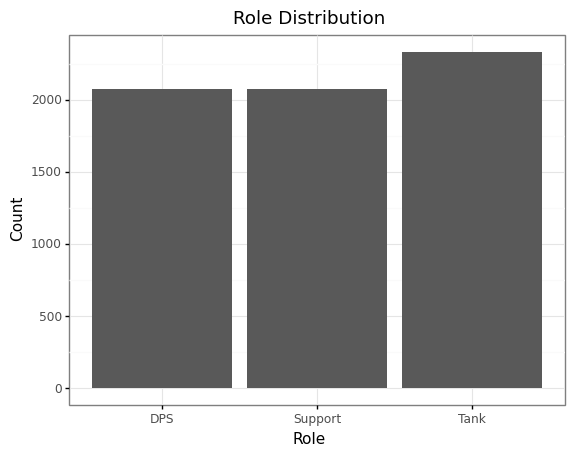

<ggplot: (8782688750547)>

In [10]:
(
    ggplot(df_final) +
        geom_bar(aes(x = "role")) + 
        labs(x = "Role", y = "Count", title = "Role Distribution") + 
        scale_x_discrete(labels = ["DPS", "Support", "Tank"]) + 
        theme_bw()
)

We can see a roughly even distribution of player roles. This is a bit surprising as DPS queue times tend to be the longest, but perhaps this indicates that role-queue has been doing its job since its introduction into the game in mid 2019, and the playerbase as a whole is less biased to certain roles as compared to before.

## Roles and Skill

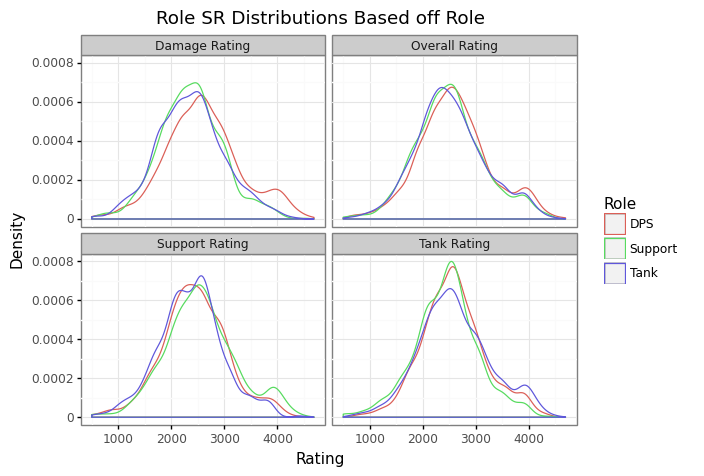

<ggplot: (8782653678234)>

In [11]:
df_ratings_long = pd.melt(df_final[["rating", "tank_rating", "damage_rating", "support_rating", "role"]], id_vars = ["role"])

def ratingLabeller(label):
    if (label == "rating"):
        return "Overall Rating"
    elif (label == "tank_rating"):
        return "Tank Rating"
    elif (label == "damage_rating"):
        return "Damage Rating"
    else:
        return "Support Rating"

(
    ggplot(df_ratings_long[df_ratings_long["value"] > 0]) + 
        geom_density(aes(x = "value", color = "role")) + 
        labs(x = "Rating", y = "Density", 
             title = "Role SR Distributions Based off Role",
             color = "Role") + 
        scale_color_discrete(labels = ["DPS", "Support", "Tank"]) + 
        facet_wrap("~variable", labeller = ratingLabeller) + 
        theme_bw()
)

The above plots show overall and role-specific SR distributions based off players' main roles. Note that players' role ratings that were equal to zero were taken as zero values simply indicate that a player does not play certain roles. The plots show that DPS players tend to have higher overall SR than other role players. Additionally, the plots indicate that players do tend to have higher role-specific ratings in their main role.

One other interesting aspect that all of these density plots have in common is that there are bumps right before 4000 SR. This could indicate that crossing the border from the masters to grandmaster (grandmaster minimum is 4000) is very tough. Another possibility is that once players hit grandmaster, they do not try and push even higher and sit at low grandmaster SR. Such players could have even stopped playing entirely, and their SR could have naturally decayed to below 4000 due to a lack of playing.

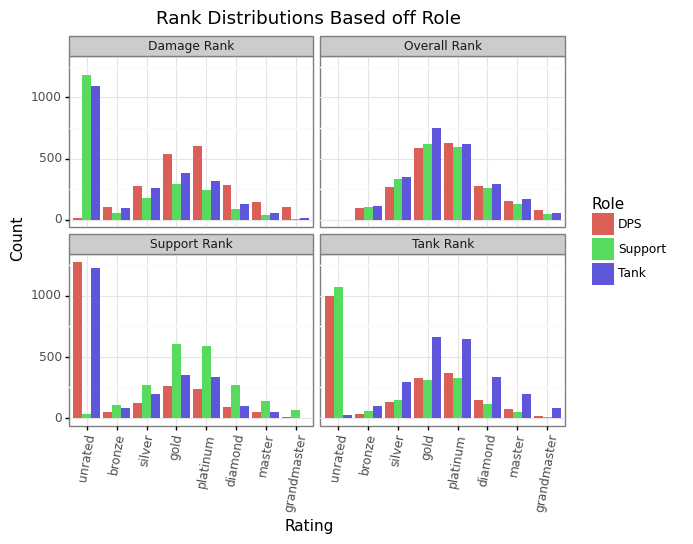

<ggplot: (8782653805297)>

In [12]:
df_ranks_long = pd.melt(df_final[["rank", "tank_rank", "damage_rank", "support_rank", "role"]], id_vars = ["role"])

ordered_rank = ["unrated", "bronze", "silver", "gold", "platinum", 
                "diamond", "master", "grandmaster"]

def ratingLabeller(label):
    if (label == "rank"):
        return "Overall Rank"
    elif (label == "tank_rank"):
        return "Tank Rank"
    elif (label == "damage_rank"):
        return "Damage Rank"
    else:
        return "Support Rank"

(
    ggplot(df_ranks_long) + #[df_ranks_long["value"] != "unrated"]
        geom_bar(aes(x = "value", fill = "role"), position = "dodge") + 
        labs(x = "Rating", y = "Count", 
             title = "Rank Distributions Based off Role",
             fill = "Role") + 
        scale_x_discrete(limits = ordered_rank) + 
        scale_fill_discrete(labels = ["DPS", "Support", "Tank"]) + 
        facet_wrap("~variable", labeller = ratingLabeller) + 
        theme_bw() + 
        theme(axis_text_x = element_text(angle = 80))
)

These histograms tell a similar story to the above density plots but include players who are unrated for certain role ratings. We can see that DPS players tend to prefer playing support over tank when not playing DPS. Support players, on the other hand, prefer playing DPS over tank, and tank players prefer support over DPS. Also note that at higher ranks, role preferences are distributed more evenely than at lower ranks.

## Roles and Heroes

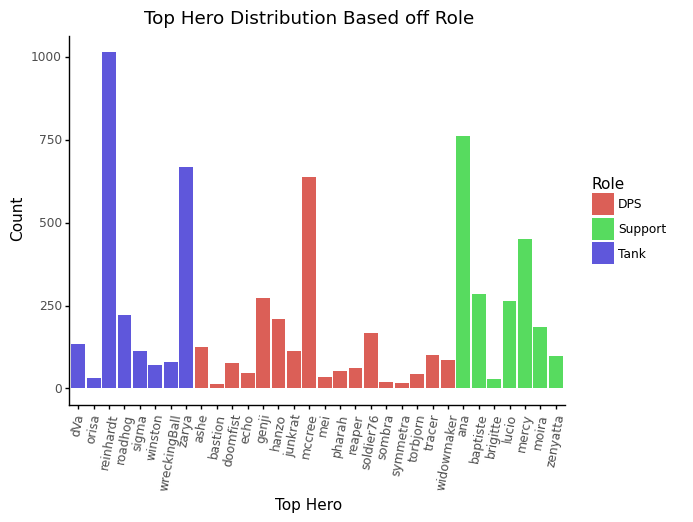

<ggplot: (8782653594103)>

In [13]:
ordered_heroes = ["dVa", "orisa", "reinhardt", "roadhog", "sigma", "winston", 
                  "wreckingBall", "zarya", "ashe", "bastion", "doomfist", "echo", 
                  "genji", "hanzo", "junkrat", "mccree", "mei", "pharah", "reaper", 
                  "soldier76", "sombra", "symmetra", "torbjorn", "tracer", "widowmaker", 
                  "ana", "baptiste", "brigitte", "lucio", "mercy", "moira", "zenyatta"]
(
    ggplot(df_final) + 
        geom_bar(aes(x = "top_hero", fill = "role")) + 
        labs(x = "Top Hero", y = "Count", 
             title = "Top Hero Distribution Based off Role", 
             fill = "Role") +  
        scale_x_discrete(limits = ordered_heroes) + 
        scale_fill_discrete(labels = ["DPS", "Support", "Tank"]) + 
        theme_classic() + 
        theme(axis_text_x = element_text(angle = 80))
)

Here is a breakdown of player mains grouped together by what role these characters are in. Because our data is from Overwatch's most recent competitive season, we are also able to get a sense of the current most popular strategies. Team compositions of Reinhardt and Zarya as tanks, McCree and another DPS character for damage, and Ana and Mercy for support are the most common. This also shows that specific characters like Orisa, Bastion, and Brigette are not currently being used (possibly due to them not being very strong against or compatible with the popular team compositions).

## Match Stats

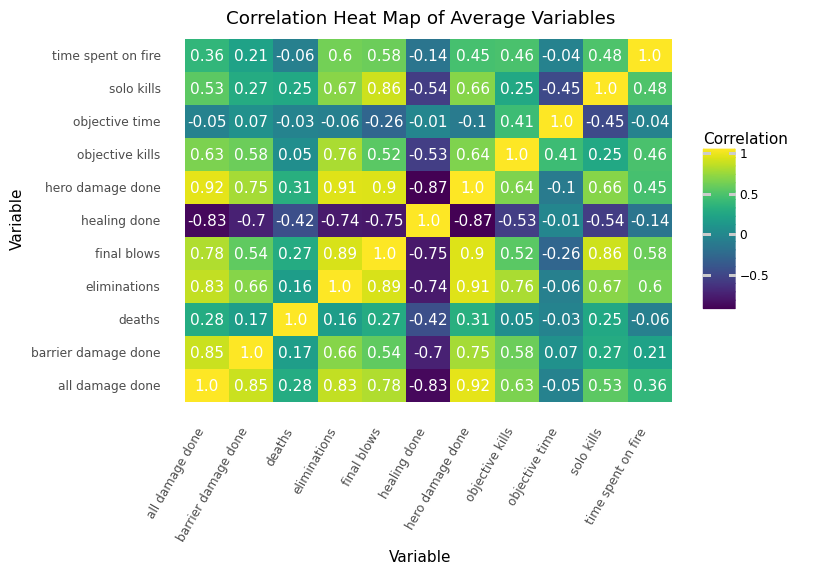

<ggplot: (8782651971569)>

In [50]:
variables = ['allDamageDoneAvgPer10Min', 'barrierDamageDoneAvgPer10Min', 
             'deathsAvgPer10Min', 'eliminationsAvgPer10Min', 
             'finalBlowsAvgPer10Min', 'heroDamageDoneAvgPer10Min', 
             'objectiveKillsAvgPer10Min', 'objectiveTimeAvgPer10Min', 
             'soloKillsAvgPer10Min', 'timeSpentOnFireAvgPer10Min', 
             'healingDoneAvgPer10Min']

def renameStats(stat):
    split = re.sub( r"([A-Z])", r" \1", stat).split()
    word = ""
    i = 0
    while (split[i] != "Avg"):
        if (word != ""): word += " "
        word += split[i].lower()
        i += 1

    return word

df_variables = df_final[variables]
df_variables["objectiveTimeAvgPer10MinSec"] = df_variables["objectiveTimeAvgPer10Min"].apply(lambda x: timeStringToSec(x))
df_variables["timeSpentOnFireAvgPer10MinSec"] = df_variables["timeSpentOnFireAvgPer10Min"].apply(lambda x: timeStringToSec(x))

df_corr = df_variables.corr()
df_corr["variable0"] = df_corr.index
df_corr["variable0"] = df_corr["variable0"].apply(lambda x:renameStats(x))
df_corr_long = df_corr.melt(id_vars = "variable0")
df_corr_long["variable"] = df_corr_long["variable"].apply(lambda x:renameStats(x))

(
    ggplot(df_corr_long.round(2), aes(x = "variable", y = "variable0")) + 
    geom_tile(aes(fill = "value")) +
    geom_text(aes(label = "value"), color = "white") +
    labs(x = "Variable", y = "Variable",
         title = "Correlation Heat Map of Average Variables",
         fill = "Correlation") +
    theme_minimal() +
    theme(axis_text_x = element_text(angle = 60, hjust = 1),
          panel_grid = element_blank()) 
)

The Pearson correlation coefficient matrix shows the linear pairwise relationship between all of the variables. Unsurprisingly, we see strong positive linear relationships between the variables related to damage, eliminations, and kills. Interestingly, we can see strong negative linear relationships between the healing done variable and almost all other variables. This makes sense as support characters tend to focus on healing over attacking during matches. Also, there is a negative linear relationship between healing done and deaths as supports are usually in the back line and end up dying last.

Note that these variables are all averaged.

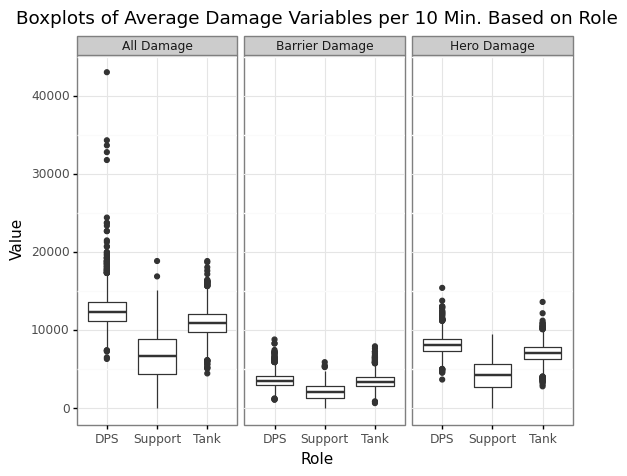

<ggplot: (8782657156160)>

In [51]:
df_damage = df_final[["allDamageDoneAvgPer10Min", "barrierDamageDoneAvgPer10Min", 
                      "heroDamageDoneAvgPer10Min", "role"]]

df_damage_long = pd.melt(df_damage, id_vars = "role")

def damageLabeller(label):
    if (label == "allDamageDoneAvgPer10Min"):
        return "All Damage"
    elif (label == "barrierDamageDoneAvgPer10Min"):
        return "Barrier Damage"
    else:
        return "Hero Damage"

(
    ggplot(df_damage_long) +
        geom_boxplot(aes(x = "role", y = "value")) +
        theme(axis_text_x = element_text(angle = 90)) +
        labs(x = "Role", y = "Value",
             title = "Boxplots of Average Damage Variables per 10 Min. Based on Role") +
        facet_wrap("~variable", labeller = damageLabeller) +
        theme_bw() +
        scale_x_discrete(labels = ["DPS", "Support", "Tank"])
)

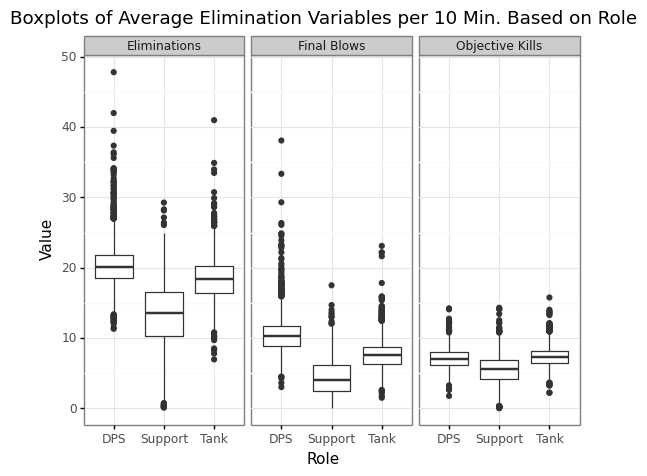

<ggplot: (8782654696698)>

In [52]:
df_elims = df_final[["eliminationsAvgPer10Min", "finalBlowsAvgPer10Min", 
                     "objectiveKillsAvgPer10Min", "role"]]

df_elims_long = pd.melt(df_elims, id_vars = "role")

def elimLabeller(label):
    if (label == "eliminationsAvgPer10Min"):
        return "Eliminations"
    elif (label == "finalBlowsAvgPer10Min"):
        return "Final Blows"
    else:
        return "Objective Kills"

(
    ggplot(df_elims_long) +
        geom_boxplot(aes(x = "role", y = "value")) +
        theme(axis_text_x = element_text(angle = 90)) +
        labs(x = "Role", y = "Value",
             title = "Boxplots of Average Elimination Variables per 10 Min. Based on Role") +
        facet_wrap("~variable", labeller = elimLabeller) +
        theme_bw() +
        scale_x_discrete(labels = ["DPS", "Support", "Tank"])
)

In [20]:
print("Tank objective kill avg: ", np.mean(df_elims[df_elims["role"] == "damage"]["objectiveKillsAvgPer10Min"]))
print("DPS objective kill avg: ", np.mean(df_elims[df_elims["role"] == "tank"]["objectiveKillsAvgPer10Min"]))

Tank objective kill avg:  7.145717726396917
DPS objective kill avg:  7.377493562231758


## Roles and Death

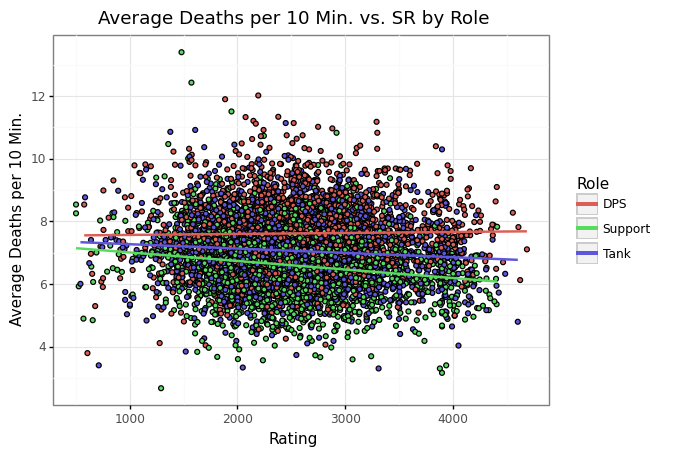

<ggplot: (8782653803274)>

In [21]:
(
    ggplot(df_final, aes(x = "rating", y = "deathsAvgPer10Min")) + 
        geom_point(aes(fill = "role")) + 
        geom_smooth(aes(color = "role"),
                    method = "lm", se = False) +
        labs(x = "Rating", y = "Average Deaths per 10 Min.", 
             title = "Average Deaths per 10 Min. vs. SR by Role",
             color = "Role", fill = "Role") + 
        scale_color_discrete(labels = ["DPS", "Support", "Tank"]) + 
        scale_fill_discrete(guide = False) + 
        theme_bw()
)

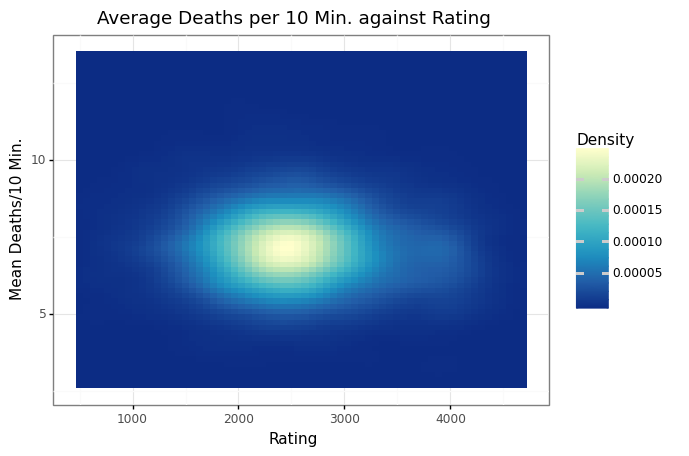

<ggplot: (8782651966410)>

In [47]:
(
    ggplot(df_final) + 
        stat_density_2d(aes(x = "rating", 
                            y = "deathsAvgPer10Min", 
                            fill = "..density.."), 
                        geom = "raster", contour = False) +
        scale_fill_distiller(palette = 16) + 
        labs(x = "Rating", y = "Mean Deaths/10 Min.",
             title = "Average Deaths per 10 Min. against Rating",
             fill = "Density") +
        theme_bw()
)

## Potato Aim Tanks or Potato Aim Supports?

In [23]:
# accuracy df_heroes
df_heroes_exp = df_heroes[(df_heroes["timePlayedSec"] > 3600) &(df_heroes["weaponAccuracy"] > 0)]

df_roles = df_final[["name", "role"]]

df_acc = df_heroes_exp[["name", "weaponAccuracy"]].groupby(by = "name", as_index = False, sort = False).mean()

df_heroes_acc = df_acc.merge(df_roles, on = "name", how = "inner")
df_heroes_acc = df_heroes_acc.groupby(by = ["name", "role"], sort = False, as_index = False).mean()
df_heroes_acc

,name,role,weaponAccuracy
0,Mercy#24868,damage,50.000000
1,LazyTurtle#29116,damage,31.833333
2,Paperclip#11793,support,28.000000
3,shadowboy#11235,damage,35.500000
4,Phienys#2456,damage,48.000000
...,...,...,...
4178,Baardaad#2568,tank,30.000000
4179,GENJI#15540,damage,49.000000
4180,Kyrann#11390,tank,32.166667
4181,Seagull#11814,support,26.000000


Those who main tank heroes like Reinhardt and Winston are often made fun of for having bad aim (also known as potato aim) due to the weapons of these heroes simply not requiring much mechanical aiming skill. We wanted to see if this was indeed the case. As such, we created a new dataframe consisting of weapon accuracy for all players.

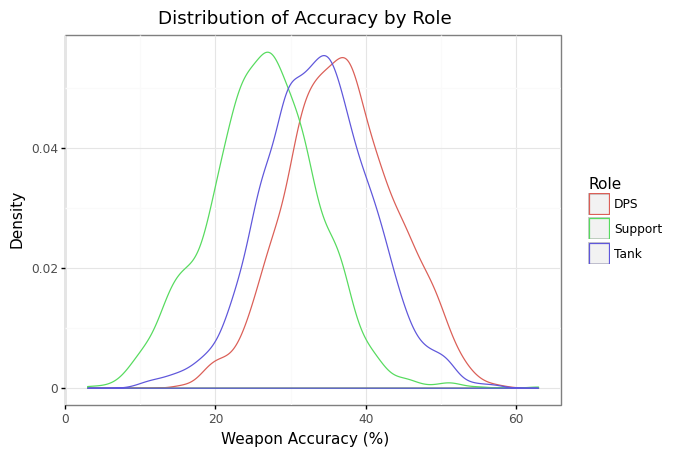

<ggplot: (8782652890790)>

In [25]:
(
    ggplot(df_heroes_acc) +
        geom_density(aes(x = "weaponAccuracy", color = "role"), alpha = .2) + 
        labs(x = "Weapon Accuracy (%)", y = "Density",
             title = "Distribution of Accuracy by Role",
             color = "Role") + 
        scale_color_discrete(labels = ["DPS", "Support", "Tank"]) +
        theme_bw()
)

Interestingly enough, it seems to be the case that support players actually have the worst aim out of the three. Perhaps the support players who main characters like Moira and Mercy who do not have kits that are aiming intensive are skewing our data. To see if this is the case, let's only look at those support players who main any one of the aiming intensive "high skill" support characters: Ana, Baptiste, or Zenyatta. 

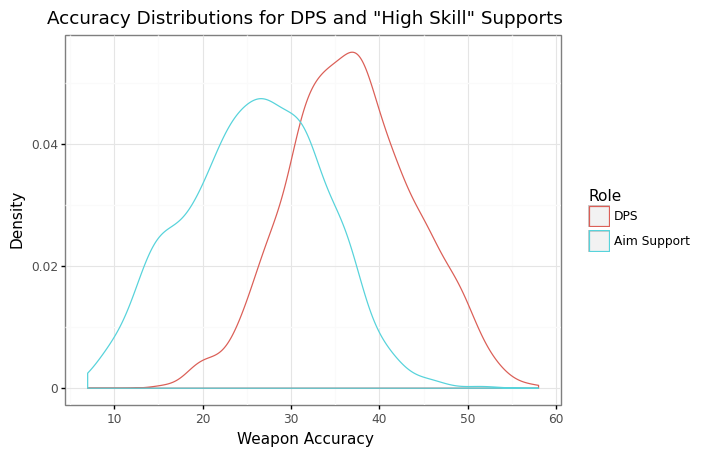

<ggplot: (8782657937716)>

In [28]:
df_aim_support_dps = df_top_hero_acc[(df_top_hero_acc["role"] == "damage") | (df_top_hero_acc["top_hero"].isin(["ana", "baptiste", "zenyatta"]))]
(
    ggplot(df_aim_support_dps) +
        geom_density(aes(x = "weaponAccuracy", color = "role")) + 
        labs(x = "Weapon Accuracy", y = "Density",
             title = "Accuracy Distributions for DPS and \"High Skill\" Supports",
             color = "Role") +
        scale_color_discrete(labels = ["DPS", "Aim Support"]) +
        theme_bw()
)

If used offensively, these characters have the potential to play similarly to DPS characters, so it would make sense to compare the two groups. However, based on the plot above, it seems that even these "high skill" support players are still worse than DPS players at aiming. To formally check this, we use a difference in means two-sample T-test.

In [33]:
aim_support = df_aim_support_dps[df_aim_support_dps["role"] == "support"]["weaponAccuracy"]
dps = df_aim_support_dps[df_aim_support_dps["role"] == "damage"]["weaponAccuracy"]

print(ttest_ind(aim_support, dps))

Ttest_indResult(statistic=-33.84066426770264, pvalue=1.7856783658392227e-203)


Our p-value of effectively zero allows us to reject the null hypothesis that there is no difference in means between the two samples.

Now knowing that support players, even those who main accuracy intensive heroes, are significantly worse at aiming than DPS players, let's return to our initial question of whether Reinhardt and Winston players truly do have potato aim.

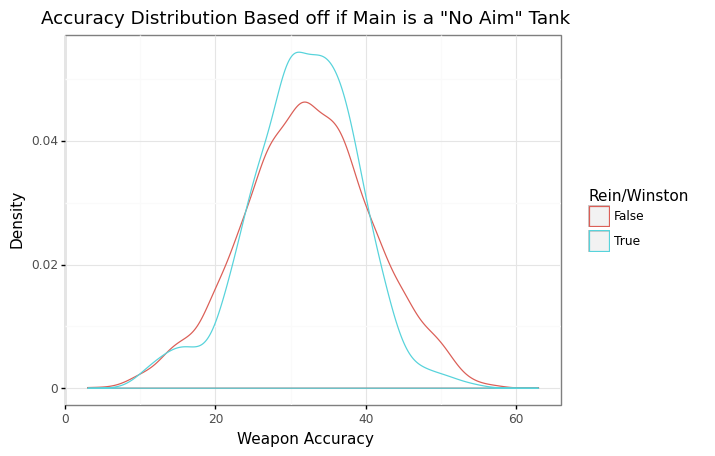

<ggplot: (8782657950160)>

In [27]:
df_top_hero_acc = df_heroes_acc.merge(df_final[["name", "top_hero"]], on = "name", how = "inner").drop_duplicates()

df_top_hero_acc["noAim"] = df_top_hero_acc["top_hero"].map(lambda x: True if x in ["reinhardt", "winston"] else False)
(
    ggplot(df_top_hero_acc) +
        geom_density(aes(x = "weaponAccuracy", color = "noAim")) +
        labs(x = "Weapon Accuracy", y = "Density",
             title = "Accuracy Distribution Based off if Main is a \"No Aim\" Tank",
             color = "Rein/Winston") +
        theme_bw()
)

The density plot above compares Reinhardt and Winston mains' accuracies against players who do not main these characters. The two distributions seem to be somewhat similar to one another.

In [45]:
rein_win = df_top_hero_acc[df_top_hero_acc["noAim"]]["weaponAccuracy"]
not_rein_win = df_top_hero_acc[~df_top_hero_acc["noAim"]]["weaponAccuracy"]

ttest_ind(rein_win, not_rein_win)

Ttest_indResult(statistic=-1.3339456378697812, pvalue=0.18229431156540662)

Another difference in means two-sample t-test was performed. At a 95% confidence level, the resulting p-value of .18 is greater than .05 indicating that we do not have sufficient evidence to reject the null hypothesis that the two samples' means are significantly different. Contrary to what many in the Overwatch playerbase feel, Reinhart and Winston mains are not actually worse at aiming than those who do not main these characters.

Note that the accuracies used for these comparisons are not the accuracies specifically for players' mains but include all accuracies for other characters that players do not main.

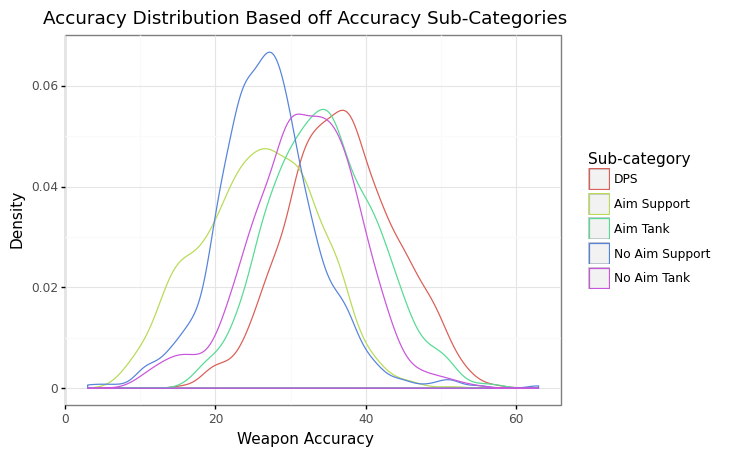

<ggplot: (8782657984708)>

In [35]:
def assignCategory(df):
    if (df["role"] == "damage"):
        return "DPS"
    elif(df["role"] == "tank"):
        if (df["top_hero"] in ["reinhardt", "winston"]):
            return "noAimTank"
        else:
            return "aimtank"
    else:
        if (df["top_hero"] in ["ana", "baptiste", "zenyatta"]):
            return "aimSupport"
        else:
            return "noAimSupport"

df_top_hero_acc["sub_cat"] = df_top_hero_acc.apply(assignCategory, axis = 1)

(
    ggplot(df_top_hero_acc) +
        geom_density(aes(x = "weaponAccuracy", color = "sub_cat")) +
        labs(x = "Weapon Accuracy", y = "Density",
             title = "Accuracy Distribution Based off Accuracy Sub-Categories",
             color = "Sub-category") +
        scale_color_discrete(labels = ["DPS", "Aim Support", "Aim Tank", "No Aim Support", "No Aim Tank"]) +
        theme_bw()
)


This plot gives an overall comparison between different groups of characters. "Aim" characters require a lot of accuracy whereas "No Aim" characters do not.

## Mercy Mains Truly Boosted Mercy?

Mercy is a support character who heals teammates via a beam of light that sticks to a teammate once attached. Mercy mains are often criticized for playing the character as it comparatively takes less skill to more or less do this a whole match. As such, players often accuse Mercy mains of being "boosted," or in other words, having a SR rating that is higher than what truly fits the player's skill. 

In [36]:
df_ratings_sub = df_final[["name", "top_hero", "role", "rating", "tank_rating", "damage_rating", "support_rating"]]

# create heroes and ratings df of only top heroes and ratings with enough experience
df_heroes_ratings_sub = df_heroes[["name", "hero", "timePlayedSec"]].merge(df_ratings_sub, on = "name")
df_heroes_ratings_sub = df_heroes_ratings_sub.drop_duplicates()

# get percent time played main 
df_time_heroes = df_heroes_ratings_sub[["name", "timePlayedSec", "top_hero", "role"]]
df_time_heroes = df_time_heroes.groupby(by = ["name", "top_hero", "role"], sort = False, as_index = False).sum()
df_time_heroes.columns = ["name", "top_hero", "role", "totalTimePlayedSec"]
df_heroes_main = df_heroes_ratings_sub[df_heroes_ratings_sub["hero"] == df_heroes_ratings_sub["top_hero"]]
df_time_heroes = df_time_heroes.merge(df_heroes_main[["name", "timePlayedSec"]])
df_time_heroes["percentMain"] = df_time_heroes["timePlayedSec"]/df_time_heroes["totalTimePlayedSec"]

mercy_main = df_time_heroes["top_hero"] == "mercy"
df_time_heroes["mercy_main"] = mercy_main
df_time_heroes

,name,top_hero,role,totalTimePlayedSec,timePlayedSec,percentMain,mercy_main
0,Mercy#24868,hanzo,damage,11795,4785,0.405680,False
1,LazyTurtle#29116,sombra,damage,102204,35896,0.351219,False
2,Paperclip#11793,baptiste,support,13290,9473,0.712792,False
3,Chizzyfizzy#1504,ana,support,15804,3324,0.210326,False
4,shadowboy#11235,genji,damage,32156,5373,0.167092,False
...,...,...,...,...,...,...,...
6594,Kyrann#11390,zarya,tank,86788,19050,0.219500,False
6595,tintix78#1300,reinhardt,tank,3640,2429,0.667308,False
6596,Seagull#11814,ana,support,37957,23066,0.607688,False
6597,Jocab#11391,zenyatta,support,33173,5691,0.171555,False


To judge if a player is boosted, we compare a player's main role rating to the player's other role ratings. An average of the difference between their main role SR to their other SR ratings can be effectively used as a boosted score with higher scores corresponding to more boosting and lower scores corresponding to the opposite.

Players who only ever role-queue for one role are removed, and role ratings of 0 are also ignored. For example, a support player with a support rating of 3000, DPS rating of 2000, and tank rating of 0 would have a boosted score of 1000 but would have a boosted score of 750 if the tank rating were actually 2500.

In [38]:
df_heroes_ratings_sub = df_heroes_ratings_sub.drop("timePlayedSec", axis = 1)

# remove one-role tricks
def oneRoleTrick(df):
    count = 0
    if (df["tank_rating"] == 0):
        count += 1
    
    if (df["damage_rating"] == 0):
        count += 1
    if (df["support_rating"] == 0):
        count += 1
        
    if (count > 1):
        return True
    else:
        return False
    
df_heroes_ratings_sub["one_role_trick"] = df_heroes_ratings_sub.apply(oneRoleTrick, axis = 1)
df_heroes_ratings_sub = df_heroes_ratings_sub[~df_heroes_ratings_sub["one_role_trick"]]

# calculate avg role sr difference
def roleSRDifference(df):
    roles = ["tank", "damage", "support"]
    role = df["role"]
    return np.mean([df[role + "_rating"] - df[label + "_rating"] for label in roles if role != label and df[label + "_rating"] > 0])

def roleRating(df):
    roles = ["tank", "damage", "support"]
    role = df["role"]
    return df[role + "_rating"]
    

def mercySupportOther(df):
    if (df["role"] == "support"):
        if (df["is_mercy_main"]):
            return "mercy"
        else:
            return "support"
    else:
        return "other"
    
df_heroes_ratings_sub["role_rating_diff"] = df_heroes_ratings_sub.apply(roleSRDifference, 1)

mercy_main = df_heroes_ratings_sub["top_hero"] == "mercy"
df_mercy_main = pd.concat([df_heroes_ratings_sub[["name", "top_hero", "role", "role_rating_diff"]], mercy_main], axis = 1)
df_mercy_main.columns = ["name", "top_hero", "role", "role_rating_diff", "is_mercy_main"]
df_mercy_main = df_mercy_main.drop_duplicates()

df_mercy_main["is_mercy_support_main"] = df_mercy_main.apply(mercySupportOther, axis = 1)
df_mercy_main

,name,top_hero,role,role_rating_diff,is_mercy_main,is_mercy_support_main
7,LazyTurtle#29116,sombra,damage,234.0,False,other
64,Chizzyfizzy#1504,ana,support,429.5,False,support
88,shadowboy#11235,genji,damage,135.0,False,other
116,Murpy#11593,soldier76,damage,-5.0,False,other
131,Phienys#2456,mccree,damage,-77.0,False,other
...,...,...,...,...,...,...
116394,KoalaTech#1685,lucio,support,283.5,False,support
116413,dragongayart#1814,roadhog,tank,148.0,False,other
116455,Kyrann#11390,zarya,tank,7.0,False,other
116485,Seagull#11814,ana,support,296.0,False,support


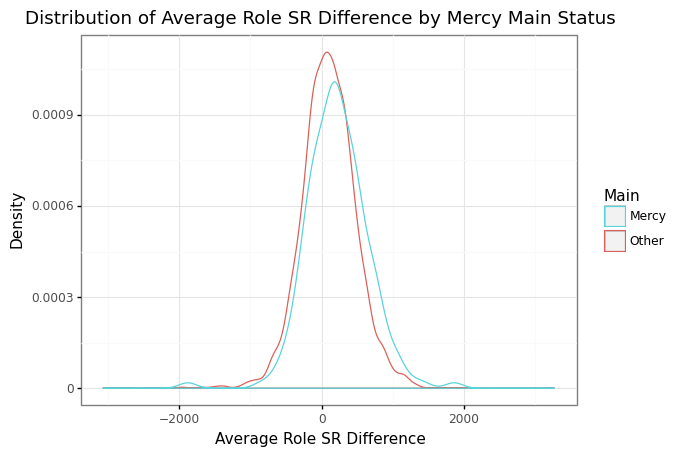

<ggplot: (8782657313717)>

In [39]:
(
    ggplot(df_mercy_main) +
        geom_density(aes(x = "role_rating_diff", color = "is_mercy_main")) +
        labs(x = "Average Role SR Difference", y = "Density",
             title = "Distribution of Average Role SR Difference by Mercy Main Status",
             color = "Main") +
        scale_color_discrete(breaks = [True, False], labels = ["Mercy", "Other"]) +
        theme_bw()
)

The above density plot of boosted scores is a bit more ambiguous when comparing the two distributions.

In [44]:
mercy_diff = df_mercy_main[df_mercy_main["is_mercy_main"]]["role_rating_diff"]
other_diff = df_mercy_main[~df_mercy_main["is_mercy_main"]]["role_rating_diff"]

ttest_ind(mercy_diff, other_diff)

Ttest_indResult(statistic=3.9125592256155297, pvalue=9.286683763997756e-05)

By doing a two-sample t-test, at a 95% condidence level, our p-value of $9.29 \times 10^{-5} < .05$ allows us to reject the null hypothesis that the means of the two samples are equal. It seems to be the case that the playerbase is actually correct here. Mercy mains really are boosted.

### Notes
A number of informative plots are included but do not have commentary due to word count restrictions. Please interpret them as you see fit.
